Status: ✅ done

## Exercise 10

---

Last exercise, we mostly focused on `univariate LDA and QDA`. In this session, we will shift the focus on `multivariate QDA and LDA`.

> Imports

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings("ignore")

### Multivariate LDA and decision regions

---

> Theory

Recall from the previous session that we can write the formula for $d(x)$ of `LDA` as:

$$
\text{argmax}_k \text{ } d(C_k| x)_{\mu_k, \Sigma} = 2\log \pi_k - (x-\mu_k)^T\Sigma^{-1}(x-\mu_k)
$$

In words, the classification decision depends on the class prior and `Mahalanobis distance` (more robust version of Euclidean distance that takes into account variance of and correlation of features). Now, consider the following figure:

![contour plots of discriminant functions](images/img1.png)

On each subplot, you see `contour` plots of LDA discriminant functions for each $k$ set to some constant value. Therefore, formally:

$$
g_k(x) = 2\log \pi_k - (x-\mu_k)^T\Sigma^{-1}(x-\mu_k) = c
$$

First, notice the points $$(x_1, x_2)$$ where the contour lines cross. For these points, it applies that:

$$
g_k(x) = g_{k'}(x)
$$

Therefore, we would have to decide randomly which $$k$$ to predict. Each classes have two pairs of such points, therefore if we draw a line through for each pair we get three lines. We can use these lines as `potential decision boundaries`. For instance, for the first subplot we can write:

![first subplot decision boundaries and regions](images/img2.jpg)

In the above plot, I first draw the three lines and obtain 6 regions for which I need to decide which class would be predicted. After this decision, I draw the actual `decision boundaries`. Similarly for the second subplot:

![second subplot decision boundaries and regions](images/img3.jpg)

Finally, for the third subplot we get:

![third subplot decision boundaries and regions](images/img4.jpg)

Now, let's consider what would happen if the priors were equal in the third example. Recall, that here we see `LDA` discriminant functions, therefore, they have common `covariance` matrices - meaning the shape of the curves is same. But they have different means - can be of course seen from the crosses. We can see that black which has by far the highest prior also has the biggest radius, whereas red classes' radius is tiny. Why is this? 

Well, imagine there are two hills, one is like Mt Everest (black class) and the other is like some small hill in Denmark (they do not have mountains in DK 😅). As you are getting closer and closer to the top, the radius of that hill is getting smaller. Now, imagine you walk like 200m uphill. For the MtEverest, the radius will be pretty large since there is a lot of km to still climb, whereas for the small Danish hill, you are almost at the top and as such the radius would be small.

One little detail I would like to add is that the reason why black class is 'MtEverest' comes simply from the fact the discriminant function is computed for each class: their class conditionals follow multivariate gaussian distribution with only different means - this only impacts the 'position of the mountain'. But then you scale the mountain by class priors and this where the difference is made.

Therefore, if we have same class priors, we would get circles with idential radiuses and only different positions based on their means.

> Section summary

In this section, we recapped how to make decision boundaries and corresponding regions based on contour plots of LDA model for each respective class. We also discussed the impact of class priors on the resulting decision.

### Multivariate LDA

---

> Intro

The focus of this exercise will be to first construct `Bayes classifier` based on the information about the true population. Then sample from it such that we obtain `training` and `test` dataset. We then fit a new `LDA` model and compare the performance of this model to the `Bayes classifier`. 

Let me highlight one important thing, in real life scenarios, you do not have access to the true population parameters. Therefore, you do not know what is the lowest achievable bayes error rate. In practice, you simply estimate the LDA's parameters and then you have to asses by for instance some `classification` metrics whether the model's performance is good enough.

Second, before going into this exercise, make sure you at least understand on a high level how we derive the formula for discriminant function of LDA (see the previous exercise where I show it).

We know the following information about class conditionals:

$$
\boldsymbol{\mu}_{\text {black }}=(2,1), \boldsymbol{\mu}_{\text {red }}=(4,2), \text { and a shared covariance matrix } \Sigma=\left[\begin{array}{rr}
3 & -1 \\
-1 & 2
\end{array}\right]
$$

and about class priors:

$$
\mathrm{P}(Y=\text { black })=0.4 \text { and } \mathrm{P}(Y=\text { red })=0.6
$$

> Bayes classifier

We start by creating the Bayes classifier with two methods that can be used for making a decision on which class to predict:

In [ ]:
class BayesClassifier:

    """Bayes Classifier based on the provided information
    """

    def __init__(self, debug=False):
        # -- class conditionals
        self.params = {
            "class_mean": [np.array([2, 1]), np.array([4, 2])],
            "covariance": np.array([[3, -1], [-1, 2]]),
            "covariance_inv": np.linalg.inv(np.array([[3, -1], [-1, 2]]))
        }

        # -- class priors
        self.priors = [.4, .6]

        # -- debugging
        self.debug = debug
    
    def discriminant_function(self, x):
        """Return discriminant function results (for each class) for given input

        Attributes
        ----------
        x : 2d array
            Each row represents one sample, each column represents features

        Returns
        -------
        result : 2d array
            n x k matrix where n is the number of inputs and k is the number of classes
        
        Todo
        ----
        I am converting back and forth list to arrays which is not so good for performance but it works 
        for educatinal purposes. Feel free to rewrite this more efficiently.
        """
        if self.debug: print("DISCRIMINANT FUNCTION RESULTS")
        if self.debug: print("="*48)

        # Result will be n, k matrix
        n, k = x.shape[0], 2

        # Result for now just 2d list
        result = []

        for i in range(n):

            # Compute the values for each discriminant
            values = []
            xin = x[i]
            for j in range(k):
                if self.debug: print(f"Class {j} information\n---")
                # Log of prior
                prior_log = 2*np.log(self.priors[j])
                if self.debug: print(">> Prior log: {:>32.3f}".format(prior_log))

                # x - u_k
                diff = (xin - self.params["class_mean"][j]).reshape((2, 1))

                # Squared Mahalonobis distance
                square_mh_distance = (diff.T @ self.params["covariance_inv"] @ diff)[0, 0]
                if self.debug: print(">> (-1)*Mahalanobis distance^2: {:>14.3f}".format(-square_mh_distance))
                if self.debug: print("-"*48)

                # Final value
                val = prior_log - square_mh_distance
                if self.debug: print(">> Final value: {:>30.3f}".format(val))

                # Save it
                values.append(val)
                if self.debug: print()

            # Save the result
            result.append(values)
        
        return np.array(result)

    def predict_probs(self, x):
        """Predict posteriors for given input

        Attributes
        ----------
        x : 2d array
            Each row represents one sample, each column represents features

        Returns
        -------
        result : 2d array
            n x k matrix where n is the number of inputs and k is the number of classes
        
        Todo
        ----
        I am converting back and forth list to arrays which is not so good for performance but it works 
        for educatinal purposes. Feel free to rewrite this more efficiently.
        """

        if self.debug: print("POSTERIOR PROBABILITIES RESULTS")
        if self.debug: print("="*48)

        # Result will be n, k matrix
        n, k = x.shape[0], 2

        # Result for now just 2d list
        result = []

        for i in range(n):

            # Compute the likelihoods
            likelihoods = []
            xin = x[i]
            for j in range(k):
                if self.debug: print(f"Class {j} information\n---")

                # Conditionals
                conditional_prob = multivariate_normal.pdf(xin, mean=self.params['class_mean'][j], cov=self.params['covariance'])
                if self.debug: print(">> Conditional probability: {:>15.3f}".format(conditional_prob))
                if self.debug: print(">> Prior probability: {:>21.3f}".format(self.priors[j]))
                if self.debug: print("-"*48)

                # Likelihood
                likelihood = conditional_prob*self.priors[j]
                likelihoods.append(likelihood)
                if self.debug: print(">> Likelihood: {:>28.3f}".format(likelihood))
                if self.debug: print()
            
            # Get posteriors
            px = sum(likelihoods)
            posteriors = list(np.array(likelihoods)/px)

            # Save the result
            result.append(posteriors)
        
        return np.array(result)
    
    def predict(self, x):
        """Decision method for this model

        Attributes
        ----------
        x : 2d array
            Each row represents one sample, each column represents features

        Returns
        -------
        result : 1d array
            Predicted classes (0 based encoding)
        """

        posteriors = self.predict_probs(x)
        result = np.argmax(posteriors, axis=1)
        return result


Let's now test our implementation:

In [ ]:
# Test input
x = np.array([[3, 1]])

# Bayes classifier
bayes_clf = BayesClassifier(debug=True)

# Get the results
discriminant_vals = bayes_clf.discriminant_function(x)
posteriors = bayes_clf.predict_probs(x)
print(f"Posteriors: {posteriors[0, 0]} (c0), {posteriors[0, 1]} (c1)")

# Test predict
bayes_clf.debug = False
print(f"Predicted class: {bayes_clf.predict(x)[0]}")

DISCRIMINANT FUNCTION RESULTS
Class 0 information
---
>> Prior log:                           -1.833
>> (-1)*Mahalanobis distance^2:         -0.400
------------------------------------------------
>> Final value:                         -2.233

Class 1 information
---
>> Prior log:                           -1.022
>> (-1)*Mahalanobis distance^2:         -1.400
------------------------------------------------
>> Final value:                         -2.422

POSTERIOR PROBABILITIES RESULTS
Class 0 information
---
>> Conditional probability:           0.058
>> Prior probability:                 0.400
------------------------------------------------
>> Likelihood:                        0.023

Class 1 information
---
>> Conditional probability:           0.035
>> Prior probability:                 0.600
------------------------------------------------
>> Likelihood:                        0.021

Posteriors: 0.523616137776949 (c0), 0.47638386222305107 (c1)
Predicted class: 0


Works, as expected, i.e., we can see that we would predict `c0` class under the 0-1 loss. First, takeaway from this part is that no matter approach you choose, the conclusion is still the same. Second takeaway is that we can nicely see how class conditionals and priors impact the final value based on which we make the decision. Let's continue by making a plot of decision regions for our `Bayes classifier`:

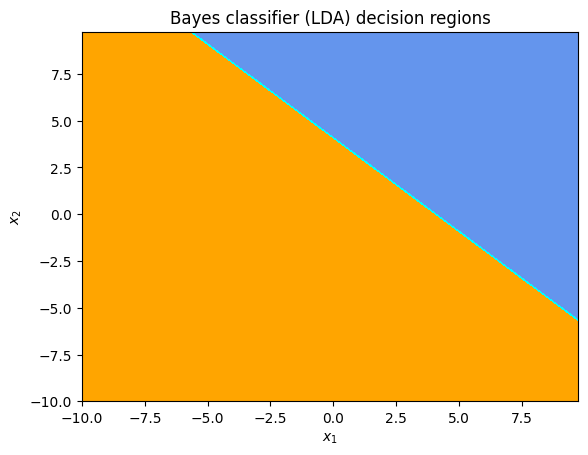

In [ ]:
# Define plot
fig, ax = plt.subplots();

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Mesh step
h = 0.25

# Set debug of the model
bayes_clf.debug = False

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = -10, 10
y_min, y_max = -10, 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot decision regions
Z = bayes_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cmap_light)

ax.set_title("Bayes classifier (LDA) decision regions");
ax.set_xlabel("$x_1$");
ax.set_ylabel("$x_2$");

As expected, we obtain linear decision boundary. Let's now continue by computing the bayes error rate.  For that we start by computing posterior probabilities of each point in the defined meshgrid:

In [ ]:
# Mesh step
h = .25

# Set debug of the model
bayes_clf.debug = False

# Define Meshgrid
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = -25, 25
y_min, y_max = -25, 25
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
points = np.c_[xx.ravel(), yy.ravel()]

# Get posterior probabilites for each input (x_1, x_2)
posteriors = bayes_clf.predict_probs(x=points)

Note that given the meshgrid above is finite, the bayes error rate that we compute is only an estimate. Now, we can compute tha actual bayes error rate which means we need to sum all the 'uncertainity' for each of our decisions and then average it. (total number of points)

In [ ]:
n = points.shape[0]
bayes_error_rate = (1 - np.amax(posteriors, axis=1)).sum()/n
print("Bayes error rate is: {:.3f}".format(bayes_error_rate))

Bayes error rate is: 0.025


> Estimating the Bayes classifier with LDA

We first start with sampling from the above defined generative model. We will then use the sample for training and testing our LDA model.

In [ ]:
# Define size of of sample
N = 3000

# Save the sampled data to these
x = []
y = []

# Define class condtional models
covariance = np.array([[3, -1], [-1, 2]])
gaussian0 = multivariate_normal(mean=[2, 1], cov=covariance)
gaussian1 = multivariate_normal(mean=[4, 2], cov=covariance)

for _ in range(N):
    p = np.random.random()
    if p < .4:
        p = np.random.random()
        sample = gaussian0.rvs()
        x.append(sample)
        y.append(0)
    else:
        p = np.random.random()
        sample = gaussian1.rvs()
        x.append(sample)
        y.append(1)

# Save it as pandas
x = np.array(x)
d = {'x1': x[:, 0], 'x2': x[:, 1], 'y': y}
data = pd.DataFrame(data=d)
data

,x1,x2,y
0,2.493945,1.192805,0
1,6.940520,0.751154,1
2,2.744042,2.688595,1
3,0.321621,0.431786,0
4,2.413939,4.626055,1
...,...,...,...
2995,-1.078884,4.059643,0
2996,3.194748,0.860022,0
2997,1.532352,1.745585,1
2998,-0.043970,0.039317,0


Next, we do train-test split:

In [ ]:
train, test = train_test_split(data, test_size=0.33)

We then fit our `LDA` model:

In [ ]:
lda = LinearDiscriminantAnalysis().fit(train[['x1', 'x2']], train['y'])

Let's see how decision regions of our fitted model compare with bayes classifier:

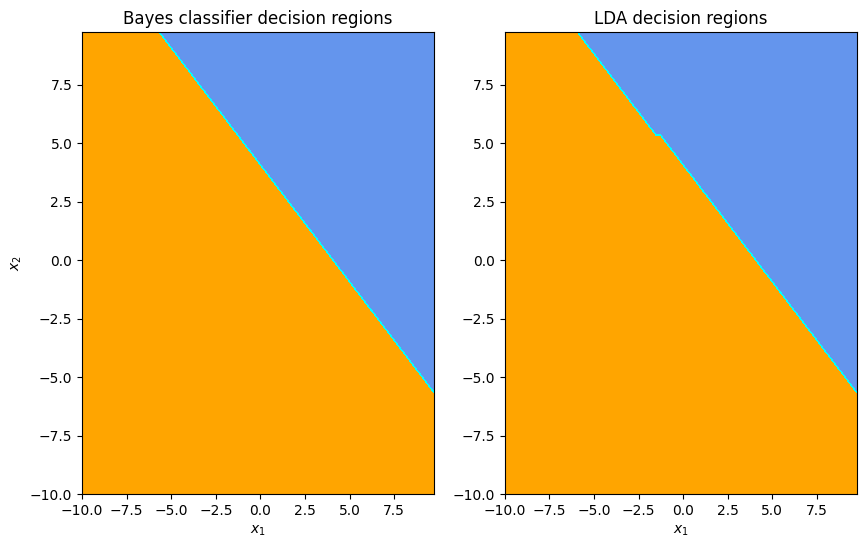

In [ ]:
# Define plot
fig, ax = plt.subplots(1, 2, figsize=(10,6), sharex=True);

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Mesh step
h = 0.25

# Set debug of the bayes model
bayes_clf.debug = False

# Define classifiers
clfs = [bayes_clf, lda]

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = -10, 10
y_min, y_max = -10, 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

for i in range(2):

    # Plot decision regions
    Z = clfs[i].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax[i].contourf(xx, yy, Z, cmap=cmap_light)

    # Plot labels
    ax[i].set_xlabel("$x_1$");
    if i == 0:
        ax[i].set_title("Bayes classifier decision regions");
        ax[i].set_ylabel("$x_2$");
    else:
        ax[i].set_title("LDA decision regions");

Looks very similar as expected. Next, we to estimate the error rate:

In [ ]:
yhat = lda.predict(test[["x1", "x2"]])
1 - accuracy_score(test["y"], yhat)

0.18585858585858583

We see that we are still quite far from the theoretical minimum.

> Section summary

In this section, we got to know better multivariate LDA. After this section, you should better understand how we compute the values for discriminant functions as well as the relationship between Bayes classifier and its estimation - in this case LDA.

### Multivariate QDA

---

> Introduction

In this section, we will examine a dataset from the previous lecture. Below is what we know about the dataset.

Class conditionals, $p(x \mid y)$ :
$$
\begin{aligned}
p(x \mid \text { black }) &=\operatorname{MVN}\left(\left[\begin{array}{l}
1 \\
4
\end{array}\right],\left[\begin{array}{cc}
1 & 0.1 \\
0.1 & 1
\end{array}\right]\right) \\
p(x \mid \text { red }) &=\operatorname{MVN}\left(\left[\begin{array}{l}
4 \\
2
\end{array}\right],\left[\begin{array}{cc}
3 & -1.3 \\
-1.3 & 3
\end{array}\right]\right) \\
p(x \mid \text { blue }) &=\operatorname{MVN}\left(\left[\begin{array}{l}
7 \\
5
\end{array}\right],\left[\begin{array}{cc}
2 & 1.2 \\
1.2 & 2
\end{array}\right]\right)
\end{aligned}
$$
Class probabilities:
$$
\begin{aligned}
\pi_{\text {black }} &=0.9 \\
\pi_{\text {red }} &=0.01 \\
\pi_{\text {blue }} &=0.09
\end{aligned}
$$

Notice, that `class conditionals` vary. Second, it is important to understand how to read the provided information, here are couple examples to give you an idea:

- expectation of feature $X_2$ when class is black: `4`
- variance of feature $X_1$ when the class is red: `3`
- covariance between features $X_1$ and $X_2$ when class is red: `-1.3`

Next, I will load the data that we are going to be using:

In [ ]:
# Training
training = pd.read_csv("Ex1-training.csv")
X_train, y_train = training[["x1", "x2"]], training["y"]

# Test
test = pd.read_csv("Ex1-test.csv")
X_test, y_test = test[["x1", "x2"]], test["y"]

> Is LDA a good fit?

We first fit the model:

In [ ]:
lda = LinearDiscriminantAnalysis(store_covariance=True).fit(X_train, y_train)

Let's inspect how its decision regions look like:

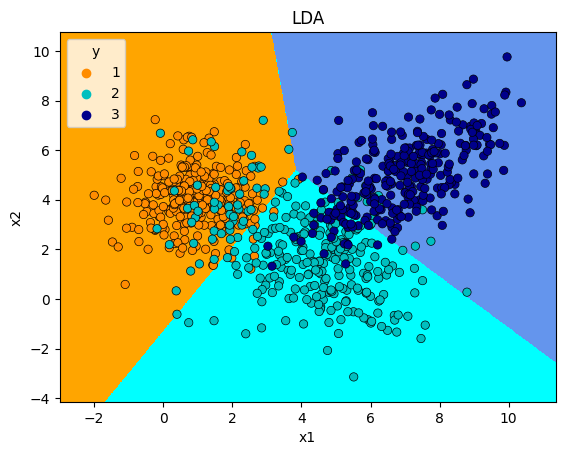

In [ ]:
# Define plot
fig, ax = plt.subplots()

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Mesh step
h = 0.02

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train["x1"].min() - 1, X_train["x1"].max() + 1
y_min, y_max = X_train["x2"].min() - 1, X_train["x2"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
ax.set_xlim(xx.min(), xx.max());
ax.set_ylim(yy.min(), yy.max());
ax.set_title(f"LDA");

Nice, looks like overall a good fit, but we can see that our model struggles quite a bit with mispredicting light blue as orange. This is suboptimal. Let's see the posterior estimatites for one of such points:

In [ ]:
x = np.array([[3, 3.5]])
posteriors = lda.predict_proba(x)
print("P(Y = orange | X) = {:.3f}".format(posteriors[0, 0]))
print("P(Y = light blue | X) = {:.3f}".format(posteriors[0, 1]))
print("P(Y = dark blue | X) = {:.3f}".format(posteriors[0, 2]))

P(Y = orange | X) = 0.430
P(Y = light blue | X) = 0.555
P(Y = dark blue | X) = 0.016


This confirms what we expected, i.e., our model is not really confident in either of the classes. Let's continue by computing the `test error`:

In [ ]:
yhat = lda.predict(X_test)
error_rate = 1 - accuracy_score(y_test, yhat)
print("Error rate for LDA: {:.3f}".format(error_rate))

Error rate for LDA: 0.133


Relatively good. Compare to `KNN` that we fitted in the exercise 7, it seems relatively the same since for `KNN` it was around `.12`. In general `LDA` seems like a decent model, but given the fact that the covariance matrices per class are different, `QDA` might be a better fit, which we will inspect in a second in the following subsection. As I mentioned in the previous exercise, when deciding which model to use, it pretty much depends on the data that you have access to. If you do not have much data, then `QDA` might not be feasible simply due to the fact that it required a lot of data in order to get good estimates for all of its parameters. If you have enough data, `LDA` might still be better since it is simpler model therefore the interpretability is easier as well as the training would be cheaper. On the other hand, if you see that the model is not performing as you need it to perform (for instance too low f1 score), then you might want to switch to more complex model like `QDA`.

> Is QDA better?

Let's again start by training the model:

In [ ]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True).fit(X_train, y_train)

And now we can visualize its decision regions:

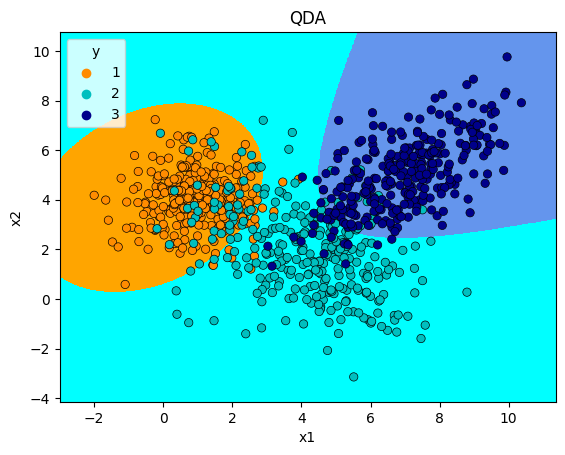

In [ ]:
# Define plot
fig, ax = plt.subplots()

# Make the predictions
Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
ax.set_xlim(xx.min(), xx.max());
ax.set_ylim(yy.min(), yy.max());
ax.set_title(f"QDA");

Very interesting, definitely the decision boundary looks more complex as expected. Btw. have you noticed that it actually almost looks the logo of `sklearn` 🤯 Nevertheless, is `QDA` better based on the error rate:

In [ ]:
yhat = qda.predict(X_test)
error_rate = 1 - accuracy_score(y_test, yhat)
print("Error rate for QDA: {:.3f}".format(error_rate))

Error rate for QDA: 0.121


Seems like we managed to slightly improve it! But is it really worthy? Again, this really depends on the particular situation as I have discussed above. Finally, let's examine `contour plots` for each respective model's class conditionals. First of all, we will define a meshgrid within which we want to draw contour lines:

In [ ]:
h = 0.02
x_min, x_max = X_train["x1"].min() - 1, X_train["x1"].max() + 1
y_min, y_max = X_train["x2"].min() - 1, X_train["x2"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
points = np.c_[xx.ravel(), yy.ravel()]
points

array([[-3.00038804, -4.14197405],
       [-2.98038804, -4.14197405],
       [-2.96038804, -4.14197405],
       ...,
       [11.31961196, 10.75802595],
       [11.33961196, 10.75802595],
       [11.35961196, 10.75802595]])

Next, we compute the corresponding probabilities (Z) for LDA:

In [ ]:
# Define class conditional distribution parameters
means = lda.means_
covariance = lda.covariance_

# Define the corresponding gaussian models
gaussian1 = multivariate_normal(mean=means[0], cov=covariance)
gaussian2 = multivariate_normal(mean=means[1], cov=covariance)
gaussian3 = multivariate_normal(mean=means[2], cov=covariance)

# Compute the corresponding Z values for each class
Z1 = gaussian1.pdf(points)
Z1 = Z1.reshape(xx.shape)

Z2 = gaussian2.pdf(points)
Z2 = Z2.reshape(xx.shape)

Z3 = gaussian3.pdf(points)
Z3 = Z3.reshape(xx.shape)

And for QDA:

In [ ]:
# Define class conditional distribution parameters
means = qda.means_
covariance = qda.covariance_

# Define the corresponding gaussian models
gaussian4 = multivariate_normal(mean=means[0], cov=covariance[0])
gaussian5 = multivariate_normal(mean=means[1], cov=covariance[1])
gaussian6 = multivariate_normal(mean=means[2], cov=covariance[2])

# Compute the corresponding Z values for each class
Z4 = gaussian4.pdf(points)
Z4 = Z4.reshape(xx.shape)

Z5 = gaussian5.pdf(points)
Z5 = Z5.reshape(xx.shape)

Z6 = gaussian6.pdf(points)
Z6 = Z6.reshape(xx.shape)

Finally, we can make the `contour plots`:

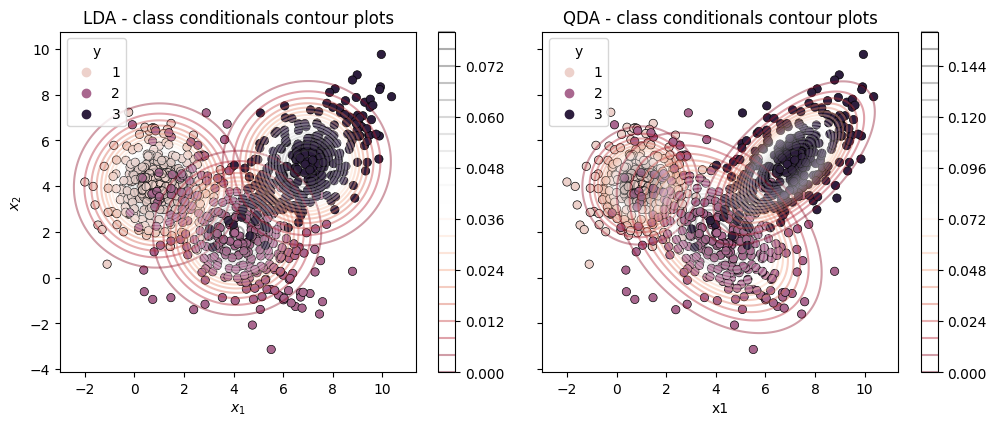

In [ ]:
# Define plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
plt.tight_layout();

# LDA contour plots
c1 = ax[0].contour(xx, yy, Z1, 20, cmap='RdGy', alpha=.4);
c2 = ax[0].contour(xx, yy, Z2, 20, cmap='RdGy', alpha=.4);
c3 = ax[0].contour(xx, yy, Z3, 20, cmap='RdGy', alpha=.4);
plt.colorbar(c1, ax=ax[0]);

# QDA contour plots
c4 = ax[1].contour(xx, yy, Z4, 20, cmap='RdGy', alpha=.4);
c5 = ax[1].contour(xx, yy, Z5, 20, cmap='RdGy', alpha=.4);
c6 = ax[1].contour(xx, yy, Z6, 20, cmap='RdGy', alpha=.4);
plt.colorbar(c4, ax=ax[1]);

# Add training data to both subplots
sns.scatterplot(x="x1", y="x2", hue="y", data=training, alpha=1.0, edgecolor="black", ax=ax[0]);
sns.scatterplot(x="x1", y="x2", hue="y", data=training, alpha=1.0, edgecolor="black", ax=ax[1]);

# Add labels
ax[0].set_xlabel("$x_1$");
ax[0].set_ylabel("$x_2$");
ax[0].set_title("LDA - class conditionals contour plots");
ax[1].set_title("QDA - class conditionals contour plots");

Uf, that was a lot of work... But we can nicely see that `QDA`'s class conditionals are relatively better fit to the provided data than `LDA`'s class conditionals. With that being said class priors also play an important role, therefore what we see here is just part of the overall decision.

> Section summary

In this section, we focused on comparing multivariate LDA and QDA models. We have done so from several perspectives, looking at their decision regions, error rates as well as contour plots of their class conditional gaussian probabilities. Hopefully, after this and previous exercise, you feel more confident about how `LDA` and `QDA` works and how we can use them in practice.

With this, I conclude this week, it is time for well-deserved Friday beer! 🍺

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=51633b18-bda1-4f40-84a8-46a61f487b88' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>